In [11]:
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.combine import SMOTEENN
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [2]:
data_2007_2020 = 'https://s3.amazonaws.com/parkerhiggins-nba-draft-bucket/07-20_MBB_StatsAndDraft.csv'

raw_df = pd.read_csv(data_2007_2020)

numerical_cols = raw_df.dtypes[raw_df.dtypes != 'object'].index.tolist()

numerical_df = raw_df[numerical_cols]
numerical_df.index = raw_df['#']

numerical_df['draft_status'] = (numerical_df['season_year']==numerical_df['draft_year']).astype(bool)

selected_features = ['ppg','rpg','apg','spg','tov','draft_status','FG%','3P%','FT%']
data_df = numerical_df[selected_features]

X = data_df.drop(columns=['draft_status'])
y = data_df['draft_status']

ipykernel_launcher:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
smoteenn = SMOTEENN(random_state=1)
X_resampled, y_resampled = smoteenn.fit_resample(X,y)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,random_state=1,test_size=0.05)

classifier = LogisticRegression(solver='lbfgs',random_state=1, max_iter=1000)
classifier.fit(X_train,y_train)

lr_pred = classifier.predict(X_test)

lr_acc_score = accuracy_score(y_test,lr_pred)
lr_matrix = confusion_matrix(y_test,lr_pred)
lr_results = pd.DataFrame({"Prediction": lr_pred, "Actual": y_test}).reset_index(drop=True)
lr_report = classification_report(y_test,lr_pred,zero_division=True)

In [5]:
print(lr_matrix)
print(lr_report)

[[ 992  186]
 [ 142 1198]]
              precision    recall  f1-score   support

       False       0.87      0.84      0.86      1178
        True       0.87      0.89      0.88      1340

    accuracy                           0.87      2518
   macro avg       0.87      0.87      0.87      2518
weighted avg       0.87      0.87      0.87      2518



In [6]:
rf = RandomForestClassifier(n_estimators=1000,random_state=1)
rf.fit(X_train,y_train)

rf_pred = rf.predict(X_test)

rf_acc_score = accuracy_score(y_test,rf_pred)
rf_matrix = confusion_matrix(y_test,rf_pred)
rf_results = pd.DataFrame({"Prediction": rf_pred, "Actual": y_test}).reset_index(drop=True)
rf_report = classification_report(y_test,rf_pred,zero_division=True)

In [7]:
print(rf_matrix)
print(rf_report)

[[1153   25]
 [   4 1336]]
              precision    recall  f1-score   support

       False       1.00      0.98      0.99      1178
        True       0.98      1.00      0.99      1340

    accuracy                           0.99      2518
   macro avg       0.99      0.99      0.99      2518
weighted avg       0.99      0.99      0.99      2518



In [8]:
importances = rf.feature_importances_
features = X.columns
feature_importances = sorted(zip(importances,features),reverse=True)

In [9]:
feature_importances

[(0.31434516868183615, 'ppg'),
 (0.1614111584225339, 'rpg'),
 (0.1557256754277993, 'FG%'),
 (0.09810254724186511, 'tov'),
 (0.08900656082532685, 'spg'),
 (0.08205148516559661, 'apg'),
 (0.05078185929443292, '3P%'),
 (0.04857554494060917, 'FT%')]

In [24]:
importance_percentages = []
feature_names = ['PPG','RPG','FG%','TOV','SPG','APG','3P%','FT%']

for feature in feature_importances:
    importance_percentages.append(feature[0])

explode = [0.1, 0, 0, 0, 0, 0, 0, 0,]

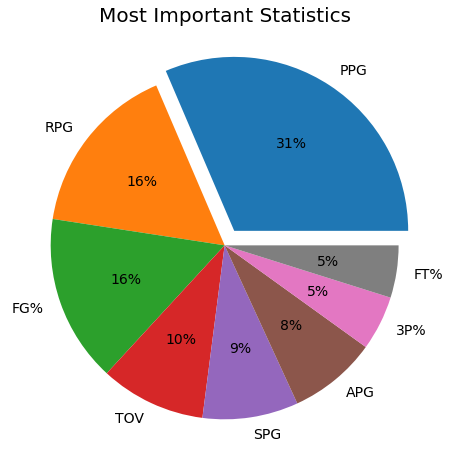

In [35]:
fig, ax = plt.subplots(figsize=(8,8))

ax.pie(importance_percentages,labels=feature_names,autopct="%.0f%%",explode=explode,textprops={'fontsize':14})
ax.set_title('Most Important Statistics', fontsize=20)
plt.savefig('../../Dashboard/static/mostImportantStatsPie.png')
plt.show()